In [1]:
import os, sys
import torch
import random
import time
import cv2
import glob
from itertools import combinations

import torch.nn as nn
import torch.optim as optim

from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from torch.autograd import Variable
from tqdm import tqdm
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score,precision_score, recall_score, average_precision_score,precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import PrecisionRecallDisplay

from torch.utils.data.sampler import BatchSampler
from pytorch_metric_learning.utils.inference import FaissKNN
import umap.umap_ as umap
#import faiss
from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from pytorch_metric_learning.utils import accuracy_calculator
import torch.nn.functional as F
from torchvision.transforms import transforms
from PIL import Image
import torchvision.models as models

Configure device

In [2]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 8

if device.type == "cuda":
    torch.cuda.get_device_name()

Create classes

In [3]:
class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """

    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()
    
        
class ImageEmbeddingNet(nn.Module):
    def __init__(self, hidden_space=1000):
        super(ImageEmbeddingNet, self).__init__()
        resnet = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        self.hidden = nn.Linear(2048, hidden_space)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1).squeeze()
        x = self.hidden(x)
        return x

    def get_embedding(self, x):
        return self.forward(x)
    
class TripletNet(nn.Module):
    def __init__(self, embedding_net):
        super(TripletNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2, x3):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        output3 = self.embedding_net(x3)
        return output1, output2, output3

    def get_embedding(self, x):
        return self.embedding_net(x)

### Create the dataset and dataloaders

Track id: 0


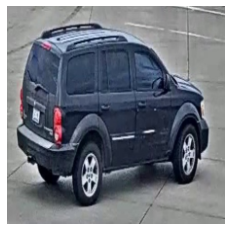

In [4]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
gen = torch.Generator()
gen.manual_seed(SEED)

data_transform = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor()])

dataset_path = './outputs/dataset/'
train_dataset = torchvision.datasets.ImageFolder(root=dataset_path+"/train/", transform=data_transform)
val_dataset = torchvision.datasets.ImageFolder(root=dataset_path+"/test/",  transform=data_transform)



# num_samples = len(train_dataset)
# train_size = int(0.1 * num_samples)
# val_size = int(0.1 * num_samples)
# test_size = num_samples - train_size - val_size

# train_dataset, val_dataset, test_coco_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size, test_size], generator=gen)

# print(f'Num images train: {len(train_dataset)}')
# print(f'Num images val: {len(val_dataset)}')
# print(f'Num images test: {len(test_coco_dataset)}')

train_dataset.train = True
val_dataset.train = False
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

image, target = train_dataset[2]
plt.axis('off')
plt.imshow(image.permute(1,2,0).numpy())
print(f'Track id: {target}')

In [5]:
class TripletDataset(Dataset):
    """
    Train: For each sample (anchor) randomly chooses a positive and negative samples
    Test: Creates fixed triplets for testing
    """

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform

        if self.train:
            self.train_labels = self.mnist_dataset.train_labels
            self.train_data = self.mnist_dataset.train_data
            self.labels_set = set(self.train_labels.numpy())
            self.label_to_indices = {label: np.where(self.train_labels.numpy() == label)[0]
                                     for label in self.labels_set}

        else:
            self.test_labels = self.mnist_dataset.test_labels
            self.test_data = self.mnist_dataset.test_data
            # generate fixed triplets for testing
            self.labels_set = set(self.test_labels.numpy())
            self.label_to_indices = {label: np.where(self.test_labels.numpy() == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(29)

            triplets = [[i,
                         random_state.choice(self.label_to_indices[self.test_labels[i].item()]),
                         random_state.choice(self.label_to_indices[
                                                 np.random.choice(
                                                     list(self.labels_set - set([self.test_labels[i].item()]))
                                                 )
                                             ])
                         ]
                        for i in range(len(self.test_data))]
            self.test_triplets = triplets

    def __getitem__(self, index):
        if self.train:
            img1, label1 = self.train_data[index], self.train_labels[index].item()
            positive_index = index
            while positive_index == index:
                positive_index = np.random.choice(self.label_to_indices[label1])
            negative_label = np.random.choice(list(self.labels_set - set([label1])))
            negative_index = np.random.choice(self.label_to_indices[negative_label])
            img2 = self.train_data[positive_index]
            img3 = self.train_data[negative_index]
        else:
            img1 = self.test_data[self.test_triplets[index][0]]
            img2 = self.test_data[self.test_triplets[index][1]]
            img3 = self.test_data[self.test_triplets[index][2]]

        img1 = Image.open(img1)
        img2 = Image.open(img2)
        img3 = Image.open(img3)
        
        # if len(img1.shape) > 2:
        #     img1 = Image.fromarray(np.uint8(img1.permute(1, 2, 0).numpy() * 255))
        #     img2 = Image.fromarray(np.uint8(img2.permute(1, 2, 0).numpy() * 255))
        #     img3 = Image.fromarray(np.uint8(img3.permute(1, 2, 0).numpy() * 255))
        # else:
        #     img1 = Image.fromarray(img1.numpy(), mode='L')
        #     img2 = Image.fromarray(img2.numpy(), mode='L')
        #     img3 = Image.fromarray(img3.numpy(), mode='L')
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            img3 = self.transform(img3)
        return (img1, img2, img3), []

    def __len__(self):
        return len(self.mnist_dataset)

In [6]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
gen = torch.Generator()
gen.manual_seed(SEED)

train_dataset.train_data = np.array([s[0] for s in train_dataset.imgs])
val_dataset.test_data = np.array([s[0] for s in val_dataset.imgs])


train_dataset.train_labels = torch.from_numpy(np.array([s[1] for s in train_dataset]))
val_dataset.test_labels = torch.from_numpy(np.array([s[1] for s in val_dataset]))

In [7]:
train_dataset.train = True
triplet_dataset_train = TripletDataset(train_dataset)

val_dataset.train = False
triplet_dataset_val = TripletDataset(val_dataset)

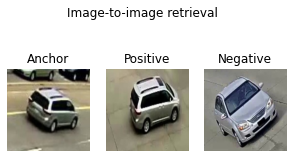

In [8]:
idx = 995

(im1, im2, im3), _ = triplet_dataset_train[idx]

plt.figure(figsize=(5,3))
plt.suptitle('Image-to-image retrieval')

plt.subplot(1,3,1)
plt.title('Anchor')
plt.axis('off')
plt.imshow(im1.permute(1, 2, 0).numpy())

plt.subplot(1,3,2)
plt.title('Positive')
plt.axis('off')
plt.imshow(im2.permute(1, 2, 0).numpy())

plt.subplot(1,3,3)
plt.title('Negative')
plt.axis('off')
plt.imshow(im3.permute(1, 2, 0).numpy())
plt.show()

### Create neural network and train

In [9]:
# The space we want to project the embeddings to. This is just a linear transformation
hidden_space_dim = 1000
im_embedding_net = ImageEmbeddingNet(hidden_space_dim)
triplet_net = TripletNet(im_embedding_net)

c:\Users\Marcos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Marcos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    torch.cuda.get_device_name()
if cuda:
    triplet_net.cuda()
# Set up the network and training parameters
margin = 1.
loss_fn = TripletLoss(margin)
batch_size = 8
lr = 1e-3
optimizer = optim.Adam(triplet_net.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 1
log_interval = 10
triplet_train_loader = torch.utils.data.DataLoader(triplet_dataset_train, batch_size=batch_size, shuffle=True)
triplet_val_loader = torch.utils.data.DataLoader(triplet_dataset_val, batch_size=batch_size, shuffle=False)

In [11]:
def train_epoch(train_loader, model, loss_fn, optimizer, cuda, log_interval, metrics):
    for metric in metrics:
        metric.reset()

    model.train()

    losses = []
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        target = target if len(target) > 0 else None
        if not type(data) in (tuple, list):
            data = (data,)
        
        if cuda:
            data = tuple(d.cuda() for d in data)
            
            if target is not None:
                target = target.cuda()


        optimizer.zero_grad()
        outputs = model(*data)
        

        if type(outputs) not in (tuple, list):
            outputs = (outputs,)

        loss_inputs = outputs
        if target is not None:
            target = (target,)
            loss_inputs += target

        loss_outputs = loss_fn(*loss_inputs)
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        for metric in metrics:
            metric(outputs, target, loss_outputs)

        if batch_idx % log_interval == 0:
            message = 'Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx * len(data[0]), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), np.mean(losses))
            for metric in metrics:
                message += '\t{}: {}'.format(metric.name(), metric.value())

            print(message)
            losses = []

    total_loss /= (batch_idx + 1)
    return total_loss, metrics

def test_epoch(val_loader, model, loss_fn, cuda, metrics):
    with torch.no_grad():
        for metric in metrics:
            metric.reset()
        model.eval()
        val_loss = 0
        for batch_idx, (data, target) in enumerate(val_loader):
            target = target if len(target) > 0 else None
            if not type(data) in (tuple, list):
                data = (data,)
            if cuda:
                data = tuple(d.cuda() for d in data)
                if target is not None:
                    target = target.cuda()

            outputs = model(*data)

            if type(outputs) not in (tuple, list):
                outputs = (outputs,)
            loss_inputs = outputs
            if target is not None:
                target = (target,)
                loss_inputs += target

            loss_outputs = loss_fn(*loss_inputs)
            loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
            val_loss += loss.item()

            for metric in metrics:
                metric(outputs, target, loss_outputs)

    return val_loss, metrics

def fit(train_loader, val_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[],
        start_epoch=0):
    """
    Loaders, model, loss function and metrics should work together for a given task,
    i.e. The model should be able to process data output of loaders,
    loss function should process target output of loaders and outputs from the model
    Examples: Classification: batch loader, classification model, NLL loss, accuracy metric
    Siamese network: Siamese loader, siamese model, contrastive loss
    Online triplet learning: batch loader, embedding model, online triplet loss
    """
    
    train_losses = []
    val_losses = []
    
    for epoch in range(0, start_epoch):
        scheduler.step()

    for epoch in range(start_epoch, n_epochs):
        scheduler.step()

        # Train stage
        train_loss, metrics = train_epoch(train_loader, model, loss_fn, optimizer, cuda, log_interval, metrics)
        message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss)
        
        for metric in metrics:
            message += '\t{}: {}'.format(metric.name(), metric.value())

        val_loss, metrics = test_epoch(val_loader, model, loss_fn, cuda, metrics)
        val_loss /= len(val_loader)

        message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f}'.format(epoch + 1, n_epochs,
                                                                                 val_loss)
        for metric in metrics:
            message += '\t{}: {}'.format(metric.name(), metric.value())

        print(message)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
    
    return train_losses, val_losses

train = False
if train:
    train_losses, val_losses = fit(triplet_train_loader, triplet_val_loader, triplet_net, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)
    print('Train losses:', train_losses)
    print('Val losses:', val_losses)
    torch.save(triplet_net.state_dict(), 'triplet_nn.pth')
else:
    triplet_net.load_state_dict(torch.load('triplet_nn_pretrained_cars_20epochs_ok.pth'))

In [12]:
from video import Video as Video

sequence = 'S03'
cam = 'c010'

root_video_path = f'../datasets/AITrack/train/{sequence}/{cam}/'
video = Video(root_video_path+'vdo.avi')
predictions = video.parse_detection_txt(f'./outputs/detections/{sequence}_{cam}.txt', roi_path=root_video_path+'roi.jpg', remove_parked_cars=False)

In [13]:
# Load the video
video = cv2.VideoCapture(root_video_path+'vdo.avi')
frame_num = 0

val_embeddings = []
val_track_ids = []
val_im_cars = []

# Open detection file
while True:
    # Read the current frame from the video
    # print(f'Frame num: {frame_num}')
    ret, frame = video.read()
        
    # Stop if there are no more frames
    if not ret:
        break
    
    if frame_num in predictions:
        for bbox in predictions[frame_num]:
            track_id = bbox['id']            
            
            im_car = frame[int(bbox['ytl']):int(bbox['ybr']), int(bbox['xtl']):int(bbox['xbr'])]
            im_car = Image.fromarray(np.uint8(im_car)[:,:,::-1])
            im_car = data_transform(im_car)
            im_car = im_car.unsqueeze(0)
            im_car = im_car.cuda()
            
            
            val_im_cars.append(im_car.permute(0,2,3,1).cpu().numpy()[0])
            
            # Coger embedding imagen
            im_embedding = triplet_net.get_embedding(im_car).data.cpu().numpy()
            
            # Pasarselo a NN y obtener imagen y label mas cercana, label sera el track id
            val_embeddings.append(im_embedding)
            val_track_ids.append(track_id)
            
    frame_num = frame_num+1

In [14]:
val_embeddings = []
val_track_ids = []
val_im_cars = []

sequence = 'S01'

for path_cam in glob.glob(f'../datasets/AITrack/train/{sequence}/*'):
    cam = os.path.basename(path_cam)
    
    root_video_path = f'../datasets/AITrack/train/{sequence}/{cam}/'
    video = Video(root_video_path+'vdo.avi')
    predictions = video.parse_detection_txt(f'./outputs/detections/{sequence}_{cam}.txt', roi_path=root_video_path+'roi.jpg', remove_parked_cars=False)

    # Load the video
    video = cv2.VideoCapture(root_video_path+'vdo.avi')
    frame_num = 0
    # Open detection file
    while True:
        # Read the current frame from the video
        # print(f'Frame num: {frame_num}')
        ret, frame = video.read()
            
        # Stop if there are no more frames
        if not ret or frame_num > 500:
            break
        
        if frame_num in predictions:
            for bbox in predictions[frame_num]:
                track_id = bbox['id']            
                
                im_car = frame[int(bbox['ytl']):int(bbox['ybr']), int(bbox['xtl']):int(bbox['xbr'])]
                im_car = Image.fromarray(np.uint8(im_car))
                im_car = data_transform(im_car)
                im_car = im_car.unsqueeze(0)
                im_car = im_car.cuda()
                
                
                val_im_cars.append(im_car.permute(0,2,3,1).cpu().numpy()[0][:,:,::-1])
                
                # Coger embedding imagen
                im_embedding = triplet_net.get_embedding(im_car).data.cpu().numpy()
                
                # Pasarselo a NN y obtener imagen y label mas cercana, label sera el track id
                val_embeddings.append(im_embedding)
                val_track_ids.append(track_id)
                
        frame_num = frame_num+1

In [15]:
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=10, metric='euclidean').fit(val_embeddings)

In [16]:
distances, indices = nbrs.kneighbors(val_embeddings, return_distance = True)

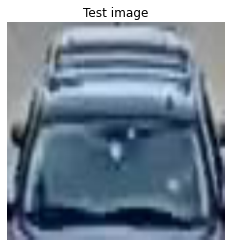

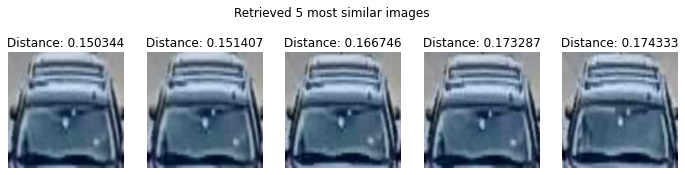

In [17]:
def get_query(idx_query, verbose=False):
    im_car_original = val_im_cars[idx_query]
    top_5_indices = indices[idx_query,1:6]
    top_5_distances = distances[idx_query,1:6]

    if verbose:
        plt.figure()
        plt.title('Test image')
        plt.axis('off')
        plt.imshow(im_car_original)
        plt.show()


        plt.figure(figsize=(12,3))
        plt.suptitle('Retrieved 5 most similar images')

        for i in range(5):
            plt.subplot(1, 5, i+1)
            plt.title('Distance: %f' %(top_5_distances[i]))
            plt.axis('off')
            plt.imshow(val_im_cars[top_5_indices[i]])
        
    # Get nearest neighboor, embedding and track id of nearest neighboor
    return top_5_indices[0], val_embeddings[top_5_indices[0]], val_track_ids[top_5_indices[0]]

get_query(2600, verbose=True)
pass

In [19]:

track_ids_used = {}
track_id_counter = 1
idx = 0
dist_th = 0.35

sequence = 'S01'

# predictions_all_cam_with_reID = []

cam_num = 0
for path_cam in glob.glob(f'../datasets/AITrack/train/{sequence}/*'):
    cam = os.path.basename(path_cam)
    
    if cam_num >= 2:
        continue
    
    # Open the output file for writing
    output_file = f'./outputs/detections_mcmt/{sequence}_{cam}.txt'
    output_fp = open(output_file, "w")
    
    root_video_path = f'../datasets/AITrack/train/{sequence}/{cam}/'
    video = Video(root_video_path+'vdo.avi')
    predictions = video.parse_detection_txt(f'./outputs/detections/{sequence}_{cam}.txt', roi_path=root_video_path+'roi.jpg', remove_parked_cars=False)
    
    predictions_with_reID = {}

    # Load the video
    video = cv2.VideoCapture(root_video_path+'vdo.avi')
    frame_num = 0
    # Open detection file
    while True:
        # Read the current frame from the video
        # print(f'Frame num: {frame_num}')
        ret, frame = video.read()
            
        # Stop if there are no more frames
        if not ret or frame_num > 500:
            break
        
        if frame_num in predictions:
            if frame_num not in predictions_with_reID:
                predictions_with_reID[frame_num] = []
            
            for bbox in predictions[frame_num]:
                track_id = bbox['id']       
                
                im_car = frame[int(bbox['ytl']):int(bbox['ybr']), int(bbox['xtl']):int(bbox['xbr'])]
                im_car = Image.fromarray(np.uint8(im_car))
                im_car = data_transform(im_car)
                im_car = im_car.unsqueeze(0)
                im_car = im_car.cuda()
                                
                # Coger embedding imagen
                im_embedding = triplet_net.get_embedding(im_car).data.cpu().numpy()
                
                nearest_object_idx, nearest_object_embedding, nearest_object_track_id = get_query(idx)
                
                new_track_id = -1
                best_distance = dist_th
            
                for track_id, embedding in track_ids_used.items():
                    distance = np.sqrt(np.sum((im_embedding - embedding)**2))
                    # print(distance)
                    if distance < best_distance:
                        best_distance = distance
                        new_track_id = track_id
                        
                        
                if new_track_id == -1:
                    track_ids_used[track_id_counter] = im_embedding
                    new_track_id = track_id_counter
                    track_id_counter += 1                    
                
                bbox['id'] = new_track_id
                predictions_with_reID[frame_num].append(bbox)
                
                # Write file to txt
                x, y, z = -1, -1, -1  # No information about x, y, z
                line = "{},{},{},{},{},{},{},{},{},{}\n".format(
                    str(int(frame_num)+1),
                    bbox['id'],
                    bbox['xtl'],
                    bbox['ytl'],
                    bbox['xbr'] - bbox['xtl'],
                    bbox['ybr'] - bbox['ytl'],
                    1,
                    x,
                    y,
                    z
                )
                output_fp.write(line)
                
                idx += 1
                
                # if idx > 100:
                #     sys.exit()   
                
        frame_num = frame_num+1
    
    #Release the output file
    output_fp.close()
    # predictions_all_cam_with_reID.append(predictions_with_reID)
    cam_num += 1

In [24]:
root_video_path = f'../datasets/AITrack/train/S01/c001/'

video = Video(root_video_path+'vdo.avi')


predictions = video.parse_detection_txt('./outputs/detections_mcmt/S01_c001.txt', roi_path=root_video_path+'roi.jpg', remove_parked_cars=False)
video.parse_video(min_frame=100, end_frame=200, create_video_annot=True, annotations=predictions, create_gif=True)


MoviePy - Building file ./outputs/video/_datasets_AITrack_train_S01_c001.gif with imageio.


In [25]:
root_video_path = f'../datasets/AITrack/train/S01/c002/'

video = Video(root_video_path+'vdo.avi')


predictions = video.parse_detection_txt('./outputs/detections_mcmt/S01_c002.txt', roi_path=root_video_path+'roi.jpg', remove_parked_cars=False)
video.parse_video(min_frame=0, end_frame=100, create_video_annot=True, annotations=predictions, create_gif=True)


MoviePy - Building file ./outputs/video/_datasets_AITrack_train_S01_c002.gif with imageio.
